# Tudatpy example application: Basic orbit estimation
Copyright (c) 2010-2021, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example implements the following ascept of orbit estimation:
- Simulation of a spacecraft orbit.
- Creation of a tracking station on Earth.
- Simulation of Doppler data at 1 mm/s every 60 seconds, during periods where the spacecraft is at an elevation angle above 15deg, as viewed from the station.
- Perturbation of the initial state of 100m (position components) and 0.1 m/s (velocity components).
- Use of the simulated data to estimate the spacecraft initial state, drag coefficient and radiation pressure coefficient.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded to convert degrees to radians, and plot results. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `obeservation` modules are new to this example.

In [1]:
# Load standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.astro import element_conversion

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `0`, corresponding to the 1st of January 2000. The times should be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0
simulation_end_epoch = 3 * constants.JULIAN_DAY

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create main the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Add a ground station
A ground station is then added. In this case, the ground station is located on Earth, in Delft, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found on [tudatpy API website](https://tudatpy.readthedocs.io/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.add_ground_station).

In [4]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Create the vehicle and its environment interface
Let's now create the satellite for which an orbit will be simulated.

This satellite is setup to have mass of 400kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, a radiation pressure coefficient of 1.2, and a drag coefficient also of 1.2.

When setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [5]:
# Create vehicle objects.
bodies.create_empty_body("Delfi-C3")
bodies.get("Delfi-C3").mass = 400.0

# Create aerodynamic coefficient interface settings
reference_area = 4.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
environment_setup.add_aerodynamic_coefficient_interface(
            bodies, "Delfi-C3", aero_coefficient_settings)

# Create radiation pressure settings
reference_area_radiation = 4.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(
            bodies, "Delfi-C3", radiation_pressure_settings)

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [6]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
First off, the acceleration settings that act on `Delfi-C3` are to be defined.
In this case, these consist in the followings:
* Gravitational acceleration using a Point Mass approximation from:
    - The Sun
    - The Moon
    - Mars
* Gravitational acceleration using a Spherical Harmonic approximation up to degree and order 8 from Earth.
* Aerodynamic acceleration from Earth.
* Acceleration caused by the radiation pressure of the Sun on the vehicle approximated as a cannonball.

The acceleration settings defined are then applied to `Delfi-C3` in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [7]:
# Define the accelerations acting on Delfi-C3
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

# Create global accelerations dictionary
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

This initial state always has to be provided as a cartesian state, in the form of a list with the first three elements reprensenting the initial position, and the three remaining elements representing the initial velocity.

In this case, let's make use of the `keplerian_to_cartesian_elementwise()` function that is included in the `element_conversion` module, so that the initial state can be input as Keplerian elements, and then converted in Cartesian elements.

In [8]:
# Set the initial state of the vehicle
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=7500.0E3,
    eccentricity=0.1,
    inclination=np.deg2rad(85.3),
    argument_of_periapsis=np.deg2rad(235.7),
    longitude_of_ascending_node=np.deg2rad(23.4),
    true_anomaly=np.deg2rad(139.87)
)

### Create the propagator settings
The propagator is finally setup.

First, a termination condition is defined so that the propagation will stop when the end epochs that was defined is reached.

Then, the translational propagator settings are defined. These are used to simulate the orbit of `Delfi-C3` around Earth.

In [9]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition
)

### Create the integrator settings
The last step before starting the simulation is to setup the integrator that will be used.

In this case, a RKF78 integrator is used with a step fixed at 60 seconds (this is done by setting both the minimum and maximum step size to 60 seconds).

In [10]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    simulation_start_epoch, 60.0, propagation_setup.integrator.rkf_78, 60.0, 60.0, 1.0, 1.0
)

### Setup the variational equations
In addition to the state of the satellite, variation equations will also be propagated.
A detailled explanation on variational equations is given in [tudatpy user guide](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/running_variational_simulation.html).

In this example, both the initial state transition matrix and the sensitivity matrix are to be propagated.
The list of the available estimated parameters for the sensitivity matrix are also given in [tudatpy user guide](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/sensitivity_analysis/available_parameters.html).

In [11]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Delfi-C3"))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameters_to_estimate(parameter_settings, bodies)

### Define the observation links and estimator
Let's now define the links of the observation model. Then, the observation settings list is saved.

Finally, the estimator object is created, taking amongst other inputs the parameters that need to be estimated (`parameters_to_estimate`) and the objservation settings (`observation_settings_list`).

In [12]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observation.transmitter] = ("Earth", "TrackingStation")
link_ends[observation.receiver] = ("Delfi-C3", "")

# Create observation settings for each link/observable
observation_settings_list = [observation.one_way_open_loop_doppler(link_ends)]

# Create the estimation object
estimator = numerical_simulation.Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    integrator_settings,
    propagator_settings)

## Simulate the observations
The observation of the `Delfi-C3` satellite over time will now be simulated.

### Setup the observations simulation
First, we need to setup the observations simulation.

This include the definition of the simulation times for each observation link, of the noise levels, and of the viability settings.

In [13]:
# Define observation simulation times for each link (separated by steps of 1 minute)
observation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 60.0)
observation_simulation_settings = observation.tabulated_simulation_settings(
    observation.one_way_doppler_type,
    link_ends,
    observation_times
)

# Add noise levels of roughly 3.3E-12 [s/m] and add this as Gaussian noise to the observation
noise_level = 1.0E-3 / constants.SPEED_OF_LIGHT
observation.add_gaussian_noise_to_settings(
    [observation_simulation_settings],
    noise_level,
    observation.one_way_doppler_type
)

# Create viability settings
viability_setting = observation.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
observation.add_viability_check_to_settings(
    [observation_simulation_settings],
    [viability_setting]
)

### Perform the observations simulation
With the observations simulation setup, we can now perform it, calling the `simulation_observations()` function from the `observation` module.

In [14]:
# Simulate required observation
simulated_observations = observation.simulate_observations(
    [observation_simulation_settings],
    estimator.observation_simulators,
    bodies)

## Estimate the parameters
After the observations have been simulated, we can now estimate a few parameters.

### Setup the parameters estimation
Let's first setup the parameters estimation model, consisting in the initial state deviation.

In [15]:
# Perturb initial position by 100m and 0.1m/s in each direction
initial_parameter_deviation = np.zeros(parameters_to_estimate.parameter_set_size)
initial_parameter_deviation[0:3] = 100.0
initial_parameter_deviation[3:6] = 0.1

# Save the truth parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector

# Create input for estimation
pod_input = estimation.PodInput(
    simulated_observations, parameters_to_estimate.parameter_set_size,
    apriori_parameter_correction=initial_parameter_deviation)
pod_input.define_estimation_settings(
    reintegrate_variational_equations=False)

# Define weights
weights_per_observable = \
    {estimation_setup.observation.one_way_doppler_type: noise_level ** -2}
pod_input.set_constant_weight_per_observable(weights_per_observable)

### Perform the estimation
Finally, let's run the estimation itself, using the inputs that have been defined earlier.

In [16]:
# Perform estimation (this also prints the residuals and partials)
pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 238
Parameter update    6459.29     2423.83    -910.259  -0.0382246    0.449098     8.58954 1.22284e+12    0.232715
Current residual: 5.20904e-07
Calculating residuals and partials 238
Parameter update     -6532.2     -2511.03      808.187   -0.0641832    -0.545295     -8.65589 -1.21653e+12    -0.213002
Current residual: 4.03572e-08
Calculating residuals and partials 238
Parameter update      6.8135     0.193996     -2.25145    0.0027012 -0.000706251    0.0112164      -420906    -0.018477
Current residual: 3.75969e-08
Calculating residuals and partials 238
Parameter update    -34.1063     -13.1717      3.99669 -9.17726e-05  -0.00287498   -0.0450003 -6.35341e+09  -0.00130553
Current residual: 7.73882e-11
Calculating residuals and partials 238
Parameter update 0.000327331  0.000103831  2.91887e-05 -5.65406e-08 -4.67526e-08  3.94218e-07      24975.7 -5.41423e-07
Current residual: 3.30227e-12
Maximum number of iterations reached
Final residual: 3.30227e-1

In [17]:
# Print the estimation error
print(pod_output.formal_errors)
print(truth_parameters - parameters_to_estimate.parameter_vector)

[1.60858847e-01 1.70140338e-01 1.67143773e-01 1.34696394e-04
 1.24426708e-04 1.41853340e-04 2.20984800e+07 3.74865310e-05]
[ 2.00662146e-01  1.79491028e-01  3.27712532e-01 -2.01622759e-04
 -2.21889721e-04  1.36231755e-04  4.08823225e+07  7.08526271e-05]


## Results post-processing
Let's now process the results of the estimation and observations.

### Correlation
First, let's plot the correlation between the outputs of the estimation.

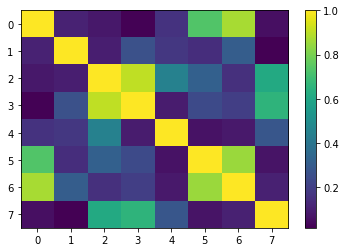

In [18]:
plt.imshow(np.abs(pod_output.correlations), aspect='auto', interpolation='none')
plt.colorbar()
plt.show()

### Range rate over time
Let's now make a plot of the observations range rate over time.

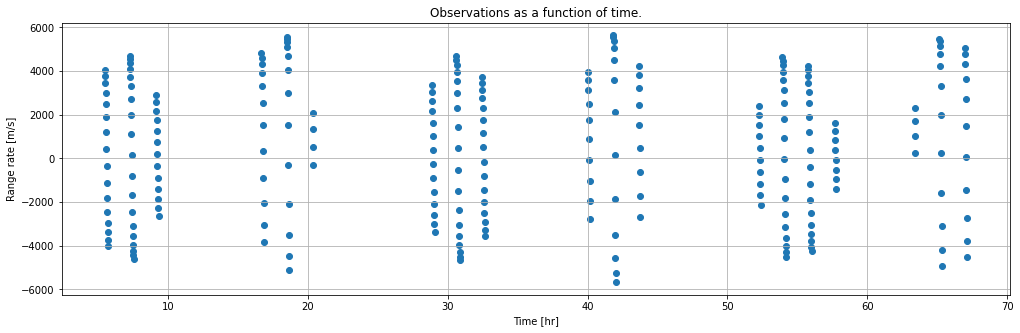

In [19]:
observation_times = np.array(simulated_observations.concatenated_times)
observations_list = np.array(simulated_observations.concatenated_observations)

plt.figure(figsize=(17, 5))
plt.title("Observations as a function of time.")
plt.scatter(observation_times / 3600.0, observations_list * constants.SPEED_OF_LIGHT)
plt.xlabel("Time [hr]")
plt.ylabel("Range rate [m/s]")
plt.grid()
plt.show()

### Residuals history
The history of residuals from the estimation can also been analysed by plotting their history.

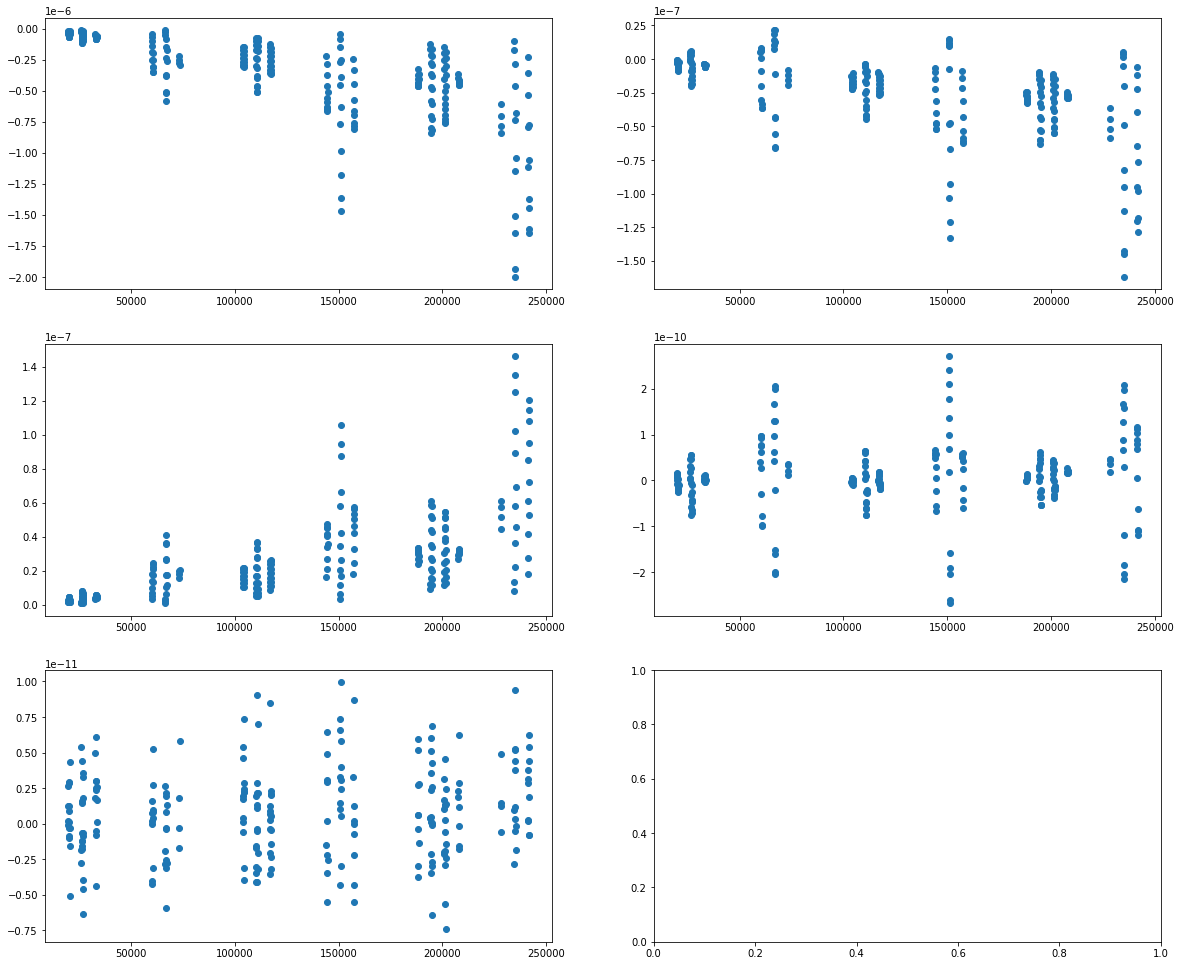

In [20]:
residual_history = pod_output.residual_history
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 17))
subplots_list = [ax1, ax2, ax3, ax4, ax5]


for i in range(5):
    subplots_list[i].scatter(observation_times, residual_history[:, i])
plt.show()

### Final residuals
Finally, we can analyse the final residuals, print them, and plot them.

[ 0.80164022  0.94790441  0.51003168 -0.66806146 -0.56075923  1.04126486
  0.54053876  0.5290775 ]


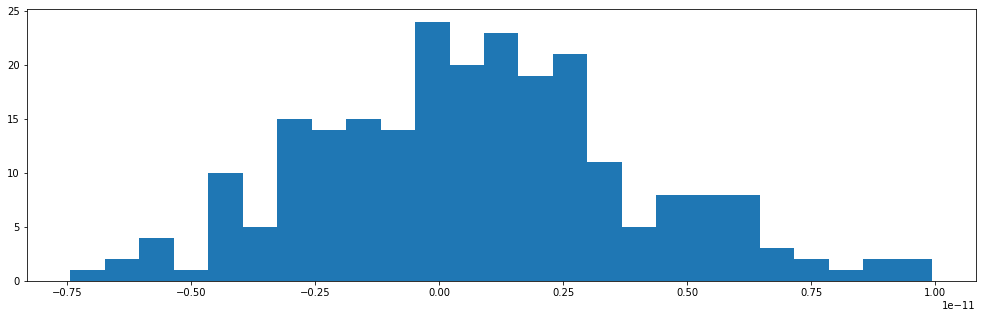

In [21]:
print(pod_output.formal_errors / (truth_parameters - parameters_to_estimate.parameter_vector))
final_residuals = pod_output.final_residuals

plt.figure(figsize=(17, 5))
plt.hist(final_residuals, 25)
plt.show()